# Project 4: Classification

### CMSC320

Mukun Guo, 2 May 2020

In this project, we aim to explore **whether standardizing affordability for each region affect prediction performance**

### Preparing data

In [1]:
import pandas as pd
import numpy as np
from plotnine import *

theme_set(theme_bw())

In [2]:
# Read and prepare data

df = (pd.read_csv('data/Affordability_Wide_2017Q4_Public.csv')
        .query('Index == "Mortgage Affordability" and SizeRank != 0')
        .drop(columns=['Index', 'HistoricAverage_1985thru1999','SizeRank'])
        .dropna()
        .melt(id_vars=['RegionID','RegionName'],
              var_name='time', value_name='affordability'))
df['time'] = pd.to_datetime(df.time, format="%Y-%m")
df.head()


,RegionID,RegionName,time,affordability
0,394913,"New York, NY",1979-03-01,0.261700
1,753899,"Los Angeles-Long Beach-Anaheim, CA",1979-03-01,0.357694
2,394463,"Chicago, IL",1979-03-01,0.261928
3,394514,"Dallas-Fort Worth, TX",1979-03-01,0.301131
4,394974,"Philadelphia, PA",1979-03-01,0.204333


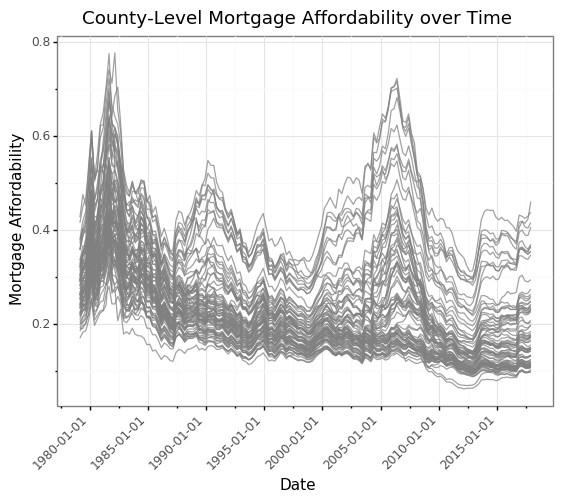

<ggplot: (7550543681)>

In [3]:
# plot data

(ggplot(df, aes(x='time', y='affordability', group='factor(RegionID)')) +
  geom_line(color="GRAY", alpha=3/4, size=1/2) +
  theme(axis_text_x=element_text(angle=45,hjust=1)) +
  labs(title="County-Level Mortgage Affordability over Time",
          x="Date", y="Mortgage Affordability"))

### The prediction task

In [4]:
outcome_dates = ['2016-12-01', '2017-12-01']
outcome_df = (df.query('time in @outcome_dates')
   .pivot(index='RegionID', columns='time', values='affordability'))

outcome_df['diff'] = outcome_df['2017-12-01'] - outcome_df['2016-12-01']
outcome_df['Direction'] = 'Down'
outcome_df['Direction'] = outcome_df['Direction'].where(outcome_df['diff'] < 0, 'Up') # this replaces where conditions is False
outcome_df = outcome_df.reset_index()[['RegionID','Direction']]
outcome_df.head()

time,RegionID,Direction
0,394304,Down
1,394312,Down
2,394318,Down
3,394347,Up
4,394355,Up


In [5]:
predictor_df = df.query('time < 20170101')

## Experiment

Questions: Does standardizing affordability for each region affect  prediction performance? Compare standardized to non-standardized affordability.

Other Decisions: We will use quarterly difference for years 2010-2016 as training dataset. We will perform logistic regression algorithm on the dataset to predict the outcome.

### Data preparation

In [59]:
# subset data and compute mean and standard deviation per region
tmp_df = predictor_df.query('time > 20091201 & time < 20170101')
stat_df = tmp_df.groupby('RegionID').agg({'affordability': ['mean', 'std']})
stat_df.columns = stat_df.columns.get_level_values(1)
stat_df.reset_index(col_level=1).set_index('RegionID')

# standardize affordability for each region
std_df = tmp_df.set_index('RegionID').join(stat_df)
std_df['std_affordability'] = (std_df['affordability'] - std_df['mean'])/std_df['std']

# switch to a 'wide' data frame
std_df['RegionID'] = std_df.index
std_df = (std_df[['RegionID','time','std_affordability']]
  .pivot(index='RegionID', columns='time', values='std_affordability'))

# construct matrix of quarterly differences
mat1 = std_df.iloc[:,1:].to_numpy()
mat2 = std_df.iloc[:,:-1].to_numpy()
std_X = mat1 - mat2

std_X

array([[-0.40519892, -0.83881845,  0.32731061, ..., -0.08163464,
         0.01620907,  1.3884486 ],
       [-0.49604902, -0.77862288,  0.16795992, ..., -0.17248354,
        -0.11423596,  1.22951772],
       [-0.39846442, -0.72163779,  0.22514358, ..., -0.20609543,
        -0.16071996,  0.83068509],
       ...,
       [-0.30490052, -0.59214947,  0.39489183, ..., -0.09552752,
        -0.12666142,  1.15506475],
       [-0.39478346, -0.76465993,  0.18964396, ...,  0.01387972,
        -0.04501034,  1.34461351],
       [-0.09784737, -0.82811947,  0.74833741, ...,  0.01457525,
        -0.14281588,  1.79911031]])

Similarly, prepare non-standardized training data

In [60]:
non_std_df = tmp_df[['RegionID', 'time', 'affordability']]
non_std_df = (non_std_df[['RegionID','time','affordability']]
  .pivot(index='RegionID', columns='time', values='affordability'))

mat1 = non_std_df.iloc[:,1:].to_numpy()
mat2 = non_std_df.iloc[:,:-1].to_numpy()
non_std_X = mat1 - mat2

non_std_X

array([[-0.00336533, -0.0069667 ,  0.00271844, ..., -0.00067801,
         0.00013462,  0.01153159],
       [-0.00738261, -0.01158811,  0.00249972, ..., -0.00256704,
        -0.00170015,  0.01829871],
       [-0.00620174, -0.01123164,  0.00350416, ..., -0.00320769,
        -0.00250146,  0.01292886],
       ...,
       [-0.01087549, -0.02112137,  0.01408539, ..., -0.00340737,
        -0.00451788,  0.04119999],
       [-0.00731382, -0.0141662 ,  0.00351337, ...,  0.00025714,
        -0.00083387,  0.02491051],
       [-0.00204139, -0.01727704,  0.01561255, ...,  0.00030408,
        -0.00297956,  0.0375348 ]])

In [61]:
# get the outcome from the dataframe we created
outcome_df['y'] = 0
outcome_df['y'] = outcome_df['y'].where(outcome_df['Direction'] == "Down", 1)
y = outcome_df['y'].to_numpy()

### Run the experiment

In [62]:
from sklearn.linear_model import LogisticRegression
import sklearn.model_selection
import sklearn.metrics
import matplotlib.pylab as plt
import numpy as np

In [63]:
logisticRegr = LogisticRegression(solver='lbfgs')

# following sklearn tutorial
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py
cv_obj = sklearn.model_selection.StratifiedKFold(n_splits=10)


def get_roc_data(model, cv_obj, X, y):
    curve_df = None
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    for i, (train, test) in enumerate(cv_obj.split(X, y)):
        model.fit(X[train], y[train])
        scores = model.predict_proba(X[test])[:,1]
        fpr, tpr, _ = sklearn.metrics.roc_curve(y[test],scores)
        
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tmp = pd.DataFrame({'fold':i, 'fpr': mean_fpr, 'tpr': interp_tpr})
        curve_df = tmp if curve_df is None else pd.concat([curve_df, tmp])
        
        aucs.append(sklearn.metrics.auc(fpr, tpr))
        
    curve_df = curve_df.groupby('fpr').agg({'tpr': 'mean'}).reset_index()
    curve_df.iloc[-1,1] = 1.0
    
    auc_df = pd.DataFrame({'fold': np.arange(len(aucs)), 'auc': aucs})
    return curve_df, auc_df

In [64]:
std_curve_df, std_auc_df = get_roc_data(logisticRegr, cv_obj, std_X, y)
std_curve_df['model'] = 'std'
std_auc_df['model'] = 'std'
non_std_curve_df, non_std_auc_df = get_roc_data(logisticRegr, cv_obj, non_std_X, y)
non_std_curve_df['model'] = 'non_std'
non_std_auc_df['model'] = 'non_std'

In [65]:
curve_df = pd.concat([std_curve_df, non_std_curve_df])
auc_df = pd.concat([std_auc_df, non_std_auc_df])

we visualize the roc for both standardized and non-standardized data

In [66]:
std_curve_df

,fpr,tpr,model
0,0.000000,0.000000,std
1,0.010101,0.350000,std
2,0.020202,0.350000,std
3,0.030303,0.350000,std
4,0.040404,0.350000,std
...,...,...,...
95,0.959596,0.846667,std
96,0.969697,0.846667,std
97,0.979798,0.846667,std
98,0.989899,0.846667,std


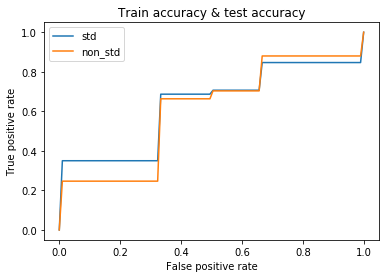

In [68]:
plt.plot(std_curve_df['fpr'], std_curve_df['tpr'], label = "std")
plt.plot(non_std_curve_df['fpr'], non_std_curve_df['tpr'], label = "non_std")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Train accuracy & test accuracy')
plt.legend()
plt.show()

Intuitively from the ROC plot, standardization improve the performance slightly. To have a more intuitive idea of its performance, we plot the distribution of auc estimates

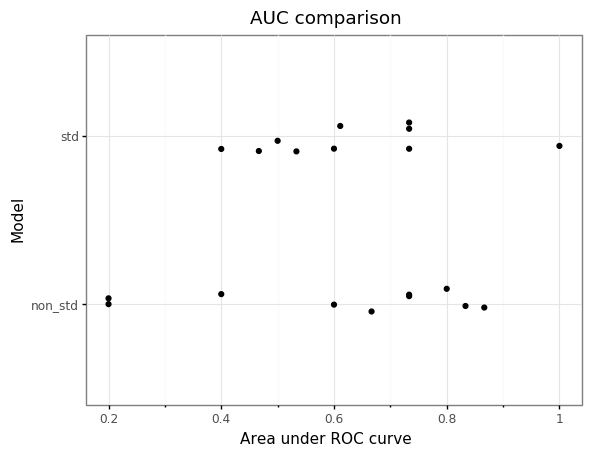

<ggplot: (7551859677)>

In [69]:
# plot the distribution of auc estimates
(ggplot(auc_df, aes(x='model', y='auc')) + 
     geom_jitter(position=position_jitter(0.1)) +
     coord_flip() +
     labs(title = "AUC comparison",
          x="Model",
          y="Area under ROC curve"))

To determine whether such difference is statistically significant, we use linear regression to test for difference

In [ ]:
# use a two-sided test (based on linear regression) to see if there is a 
# statistically significant difference in auc estimates
import statsmodels.formula.api as smf
lm_fit = smf.ols('auc~model', data=auc_df).fit()